In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
df=pd.read_csv('Fraud.csv')
#Data Shape
df.shape

(6362620, 11)

In [4]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [5]:
#Check information of data loaded
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# 1. Data cleaning including missing values, outliers and multi-collinearity. 

In [6]:
#Null Values check
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


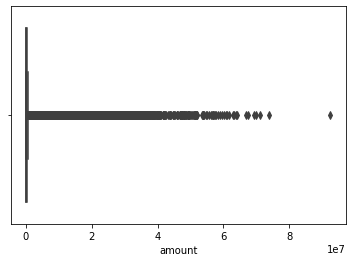

In [8]:

 # Removing the outlier
sns.boxplot(df.amount)
plt.show()

In [9]:
max(df.amount)

92445516.64

In [10]:
df['amount'].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

In [11]:
df[df.amount>85000000.00].shape

(1, 11)

In [12]:
df=df[df.amount<85000000.00]  # Removing the outlier

In [13]:
df[df.amount>85000000.00].shape

(0, 11)

We have cleared the outlier.We will continue with univariate , bivariate and multivariate analysis to find some specific insights for fraud detection through data visualization

In [14]:
df.type.value_counts(normalize=True)

CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: type, dtype: float64

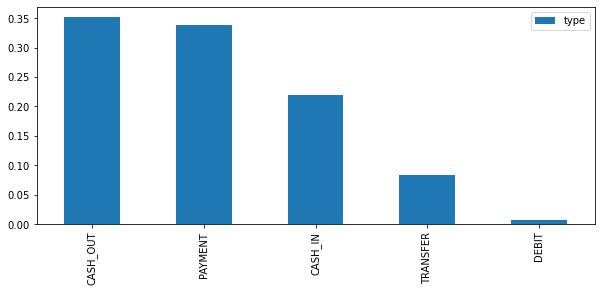

In [15]:
plt.figure(figsize=[10,4])
df.type.value_counts(normalize=True).plot.bar()
plt.legend()
plt.show()

In [6]:
#Number and percent of not fraud and fraud transactions
not_fraud = len(df[df.isFraud == 0])
fraud = len(df[df.isFraud == 1])
legit_percentage = (not_fraud / (fraud + not_fraud)) * 100
fraud_percentage = (fraud / (fraud + not_fraud)) * 100
print("No.of Legit transactions: ", not_fraud)
print("No.of Fraud transactions: ", fraud)
print("Legit transactions %: {:.4f} %".format(legit_percentage))
print("Fraud transactions %: {:.4f} %".format(fraud_percentage))

No.of Legit transactions:  6354407
No.of Fraud transactions:  8213
Legit transactions %: 99.8709 %
Fraud transactions %: 0.1291 %


These results prove that this is a highly unbalanced data as Percentage of Legit transactions= 99.87 % and Percentage of Fraud transactions= 0.129 %.
So decision tree and random forest are good methods for imbalanced data.

In [7]:
#Finding transaction id starting with M
X = df[df['nameDest'].str.contains('M')]
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


<AxesSubplot:>

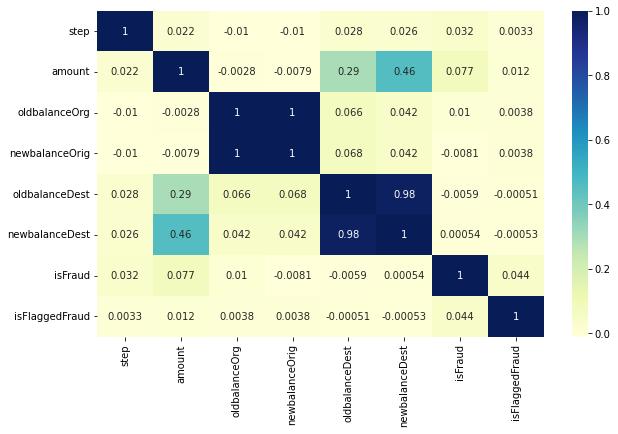

In [8]:
#Finding the correlation
corr=df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True,cmap='YlGnBu')

According to the heatmap newbalacedest & oldbalancedest, amount & newbalancedest , amount & oldbalance dest are correclation in descending order.

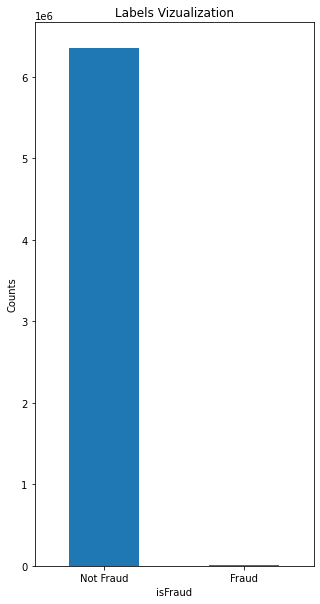

In [9]:
plt.figure(figsize=(5,10))
labels = ["Not Fraud", "Fraud"]
count_classes = df.value_counts(df['isFraud'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Labels Vizualization")
plt.ylabel("Counts")
plt.xticks(range(2), labels)
plt.show()

Fraudulent transactions are very low compared to non-frafulent transactions

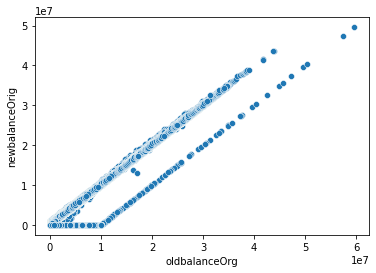

In [16]:
sns.scatterplot(data=df,x='oldbalanceOrg',y='newbalanceOrig')
plt.show()

oldbalanceOrg vs oldbalanceDest vs isFraud newbalanceOrig vs newbalanceDest vs isFraud

In [10]:
#Making copt of data
new_df=df.copy()
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
#LABEL ENCODING
object_list = new_df.select_dtypes(include = "object").columns
print (object_list)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [12]:
#Using label encoder to encode object data type column
le = LabelEncoder()
for f in object_list:
    new_df[f] = le.fit_transform(new_df[f].astype(str))
print (new_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(3), int64(3)
memory usage: 461.2 MB
None


There are 3 attributes with object datatype. Thus we need to label encode them in order to check multicolinearity.

In [13]:
#MULTICOLINEARITY
def vif_result (df):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

vif_result(new_df)

,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


In [14]:
new_df['Actual_amt_orig'] = new_df.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
new_df['Actual_amt_dest'] = new_df.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
new_df['Trans_Path'] = new_df.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

<AxesSubplot:>

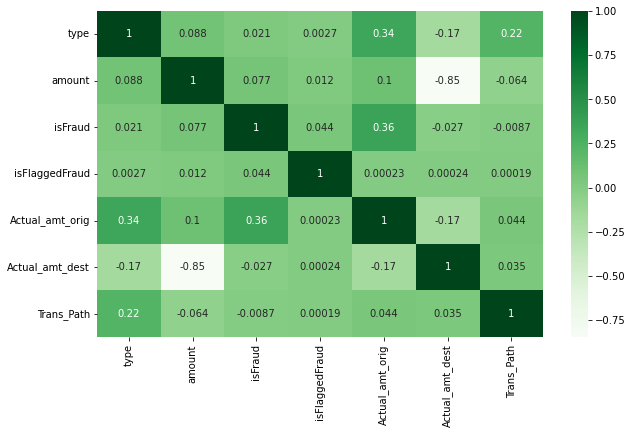

In [15]:
#Dropping the columns
new_df = new_df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)
vif_result(new_df)
corr=new_df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True,cmap='Greens')

# 3.How did you select variables to be included in the model?


Variables which are having high correlation and are related to our output i.e. fraudulent and non-fraudulent transaction data.Using the VIF values and correlation heatmap. We just need to check if there are any two attributes highly correlated to each other and then drop the one which is less correlated to the isFraud Attribute.

In [17]:
#NORMALIZING
scaler = StandardScaler()
new_df["NormalizedAmount"] = scaler.fit_transform(new_df["amount"].values.reshape(-1, 1))
new_df.drop(["amount"], inplace= True, axis= 1)
Y = new_df["isFraud"]
X = new_df.drop(["isFraud"], axis= 1)

In [18]:
# Split the data
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 42)
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4453834, 6)
Shape of X_test:  (1908786, 6)


In [19]:
#MODEL TRAINIG
# DECISION TREE-highly unbalanced dataset
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_dt = decision_tree.predict(X_test)
decision_tree_score = decision_tree.score(X_test, Y_test) * 100

In [20]:
# RANDOM FOREST
random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(X_train, Y_train)
Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, Y_test) * 100

In [21]:
#Checking scores
print("Decision Tree Score: ", decision_tree_score)
print("Random Forest Score: ", random_forest_score)

Decision Tree Score:  99.92340681459315
Random Forest Score:  99.95882199471286


# 2. Describe your fraud detection model in elaboration. 


Random forest makes multiple decision trees which makes it easier (although time taking) for model to understand 
the data in a simpler way since Decision Tree makes decisions in a faster way 
We have seen that Accuracy of both Random Forest and Decision Tree is equal, although the precision of Random Forest is more. 
In a fraud detection model, Precision is highly important because rather than predicting normal transactions correctly 
we want Fraud transactions to be predicted correctly and Legit to be left off.If either of the 2 reasons are not fulfiiled 
we may catch the innocent and leave the culprit.
This is also one of the reason why Random Forest and Decision Tree are used unstead of other algorithms.
Also the reason I have chosen this model is because of highly unbalanced dataset (Legit: Fraud :: 99.87:0.13).
Random forest makes multiple decision trees which makes it easier (although time taking) 
for model to understand the data in a simpler way since Decision Tree makes decisions in a boolean way.
Models like XGBoost, Bagging, ANN, and Logistic Regression may give good accuracy but 
they won't give good precision and recall values.


In [22]:
# confusion matrix- decision tree
confusion_matrix_dt = confusion_matrix(Y_test, Y_pred_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt,)
print(".........................................")
# confusion matrix - Rrandom forest
confusion_matrix_rf = confusion_matrix(Y_test, Y_pred_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)

Confusion Matrix - Decision Tree
[[1905609     742]
 [    720    1715]]
.........................................
Confusion Matrix - Random Forest
[[1906290      61]
 [    725    1710]]


In [23]:
# classification report - Decision Tree
classification_report_dt = classification_report(Y_test, Y_pred_dt)
print("Classification Report - Decision Tree")
print(classification_report_dt)

print("........................")

# classification report - Random Forest
classification_report_rf = classification_report(Y_test, Y_pred_rf)
print("Classification Report - Random Forest")
print(classification_report_rf)

Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.70      0.70      0.70      2435

    accuracy                           1.00   1908786
   macro avg       0.85      0.85      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786

........................
Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.97      0.70      0.81      2435

    accuracy                           1.00   1908786
   macro avg       0.98      0.85      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786



# 4. Demonstrate the performance of the model by using best set of tools. 

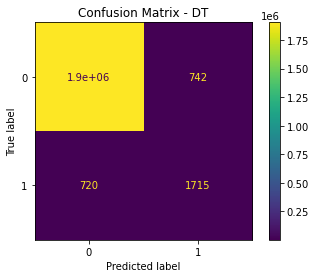

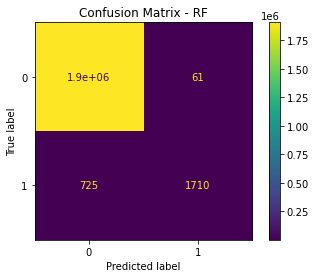

In [24]:
# visualising confusion matrix - Decision tree
dsp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt)
dsp.plot()
plt.title('Confusion Matrix - DT')
plt.show()
# visualising confusion matrix - Random forest
dsp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
dsp.plot()
plt.title('Confusion Matrix - RF')
plt.show()

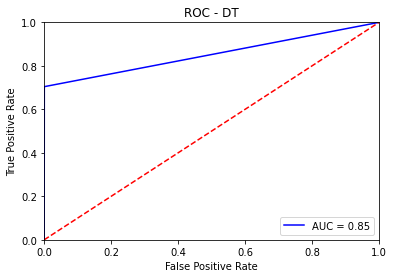

In [25]:
# AUC ROC - Decision Tree
#fpr and tpr for all thresholds

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_dt)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC - DT')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

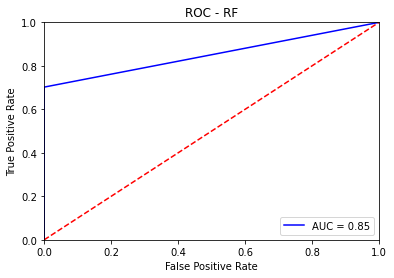

In [26]:
# AUC ROC - Random Forest
# fpr and tpr for all thresholds

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_rf)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC - RF')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Both the roc and auc are similar which indicates both models are good

# 5. What are the key factors that predict fraudulent customer? 


1.The source of request is secured or not ?

2.Is the name of organisation asking for money is legit or not ?

3.Transaction history of vendors.

# 6.Do these factors make sense? If yes, How? If not, How not? 

Yes, all the factors make sense as all these factors are depends on fraud detection.

# 7. What kind of prevention should be adopted while company update its infrastructure?

1.Use smart vertified apps only.

2.Browse through secured websites.

3.Use secured internet connections (USE VPN).

4.Keep your mobile and laptop security updated.

5.Don't respond to unsolicited calls/SMS(s/E-mails.

6.If you feel like you have been tricked or security compromised, contact your bank immidiately.

# 8. Assuming these actions have been implemented, how would you determine if they work?

1.Bank sending E-statements.

2.Customers keeping a check of their account activity.

3.Always keep a log of your payments.